In [1]:
PLT_CELL = 500

500

In [2]:
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using MultivariateStats
using NNlib
using Discretizers
using EvalMetrics

FIG_DIR = "/home/stephenz/stephenz/sc-causal-grn/figures/"

"/home/stephenz/stephenz/sc-causal-grn/figures/"

In [3]:
Nq = 500
epfrac = 0.1

0.1

In [4]:
DATA_PATH="/home/stephenz/stephenz/sc-causal-grn/manuscript/data_simulation/data/Synthetic_1000/dyn-SW/dyn-SW-1000-2/"
cd(DATA_PATH)

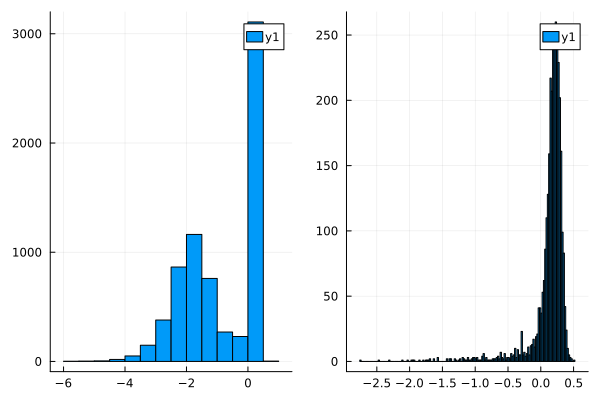

In [5]:
X_raw = npzread("X.npy")
X = relu.(X_raw .- 10^(-0.5));
plot(histogram(log10.(vec(X_raw))), 
    histogram(log10.(vec(X))))

In [6]:
Ng = size(X, 2)
rm_diag(A) = A - Diagonal(diag(A))
preprocess_cespgrn(x) = hcat([vec(rm_diag(reshape(x, Ng, Ng))) for x in eachrow(x)]...)'

preprocess_cespgrn (generic function with 1 method)

In [10]:
using Random
using Distributions

In [12]:
X_pca = npzread("X_pca.npy")
X_umap = npzread("X_pca.npy")
P = npzread("P_velo_dot.npy")
J = permutedims(npzread("J.npy"), [1, 3, 2])
C = npzread("C.npy")
dpt = npzread("dpt.npy");

In [13]:
# using GraphPlot
# using SimpleGraphs
# gplot(SimpleGraph(P + P'), X_pca[:, 1], X_pca[:, 2])

In [14]:
maximum(P)

0.9996150189309684

In [15]:
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5*mean(C));

In [16]:
gene_idxs = vcat([[j, i]' for i = 1:size(X, 2) for j = 1:size(X, 2)]...);

In [17]:
k = 3
π_unif = fill(1/size(P, 1), size(P, 1))'
Q = (P' .* π_unif)./(π_unif * P)';
R_sp = sparse(R)
QT_sp = sparse((Q^k)')
P_sp = sparse((P^k));

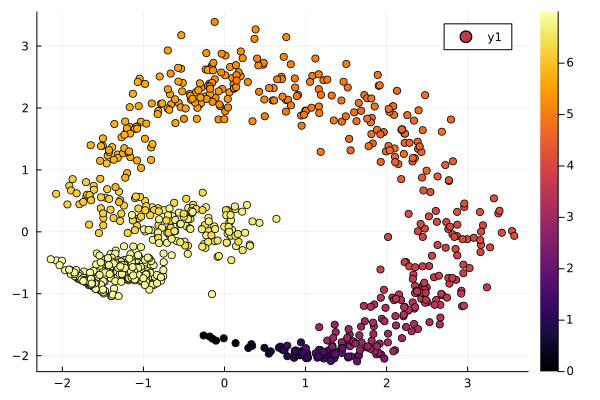

In [18]:
scatter(X_umap[:, 1], X_umap[:, 2], marker_z = log1p.(C[sortperm(dpt)[1], :]))

In [19]:
scatter(X_umap[:, 1], X_umap[:, 2], marker_z = dpt, c = :viridis, legend = nothing, colorbar = nothing, markerstrokewidth = 0, xlabel = "PCA1", ylabel = "PCA2", size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_pca.pdf"))

In [20]:
heatmap((R * P * R)[sortperm(dpt), :][:, sortperm(dpt)], 
    clim = (0, quantile(vec(P[P .> 0]), 0.5)), c = :viridis, colorbar = nothing, size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_P.pdf"))

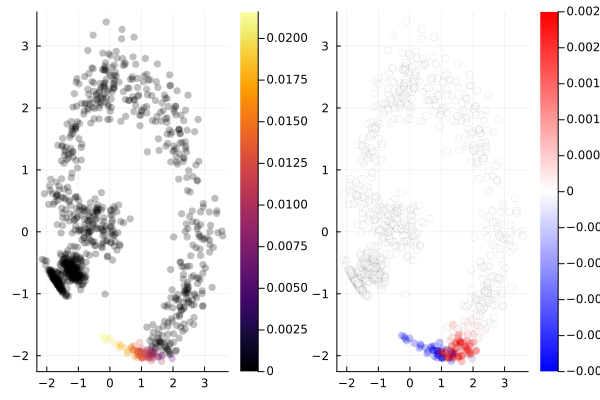

In [21]:
p0 = R[sortperm(dpt)[1], :]
plot(scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = p0, markerstrokewidth = 0, alpha = 0.25), 
    scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = P_sp'*p0 - p0, color = :bwr, clim = (-0.0025, 0.0025), markerstrokewidth = 0.25, alpha = 0.25); legend = nothing)

In [22]:
# construct kNN and Laplacian
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

In [23]:
# directed inference
@info "Directed inference"
mi_all = zeros(size(X, 1), size(X, 2)^2);
@info "Computing RDI scores"
p = Progress(size(X, 1));
alg = DiscretizeBayesianBlocks()
disc = locaTE.discretizations_bulk(X; alg = alg)
@threads for i = 1:size(X, 1)
    mi_all[i, :] = get_MI(X, compute_coupling(X, i, P_sp, QT_sp, R_sp), gene_idxs[:, 1], gene_idxs[:, 2]; disc = disc, alg = alg)
    next!(p)
end
@info "Applying CLR"
mi_all_clr = apply_wclr(mi_all, size(X, 2))
mi_all_clr[isnan.(mi_all_clr)] .= 0;

[ Info: Directed inference
[ Info: Computing RDI scores
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
[ Info: Applying CLR


In [45]:
@info "Denoising"
w = normalize(vec(sqrt.(sum(mi_all_clr.^2; dims = 2))), 1)
# G = fitsp(mi_all_clr, L, Diagonal(w); λ1 = 5.0, λ2 = 0.001, maxiter = 100);
G = fitsp(mi_all_clr, L; λ1 = 25.0, λ2 = 0.001, maxiter = 250);
G_symm = locaTE.symm_row(G, size(X, 2));

[ Info: Denoising
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
[ Info: ΔX = 1.1152633543608394e-7, ΔZ = 1.6622115426002948e-5, ΔW = 5.259620923769859e-5
[ Info: tr(X'LX) = 0.17191782782760048, 0.5|X-G|^2 = 1.395514059016213, |X|1 = 313.52111424778445


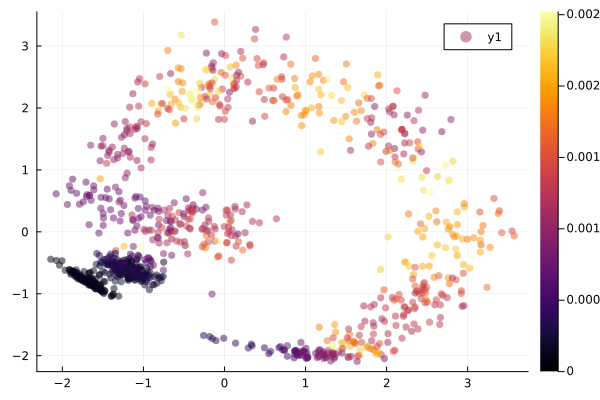

In [46]:
# TE density 
scatter(X_umap[:, 1], X_umap[:, 2]; marker_z = w, markerstrokewidth = 0, clim = (0, quantile(w, 0.995)), alpha = 0.5)

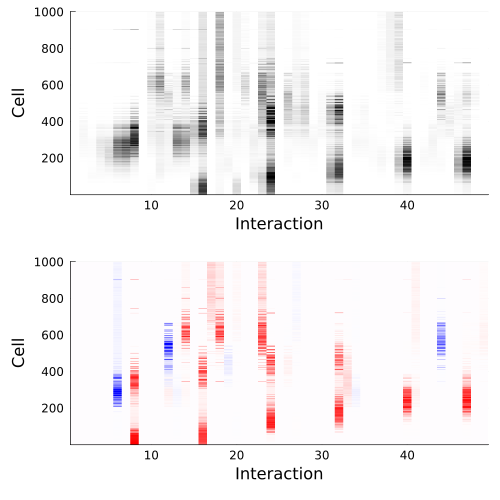

In [47]:
plt=plot(heatmap(G[sortperm(dpt), :]; xlabel = "Interaction", ylabel = "Cell", c = cgrad([:white, :black]), clim = (0, quantile(vec(G), 0.995))), 
    heatmap((R * reshape(J, :, size(X, 2)^2))[sortperm(dpt), :], c = :bwr, clim = (-1.5, 1.5); xlabel = "Interaction", ylabel = "Cell"),
    colorbar = nothing, layout = (2, 1), size = (PLT_CELL,PLT_CELL))
savefig(string(FIG_DIR, "switch_sim_network_matrix.pdf"))
plt

In [48]:
id = npzread("clusterid.npy");

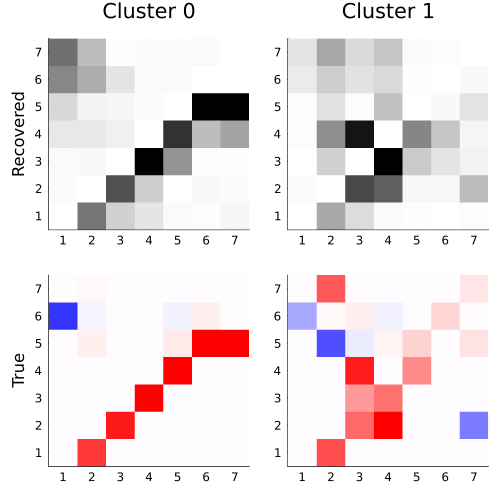

In [49]:
plt1=plot([heatmap(normalize(reshape(mean(G[id .== i, :]; dims = 1), size(X, 2), size(X, 2)), Inf), c = cgrad([:white,  :black]), title = "Cluster $i", clim = (0, 0.9), ylabel = i == 0 ? "Recovered" : "") for i in sort(unique(id))]...; layout = (1, 2), colorbar = nothing)
plt2=plot([heatmap(normalize(mean(J[id .== i, :, :]; dims = 1)[1, :, :], Inf); c = :bwr, clim = (-0.9, 0.9), ylabel = i == 0 ? "True" : "") for i in sort(unique(id))]...; layout = (1, 2), colorbar = nothing)
plt=plot(plt1, plt2; layout = (2, 1), size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_sim_network_cluster_averages.pdf"))
plt

In [50]:
using Colors

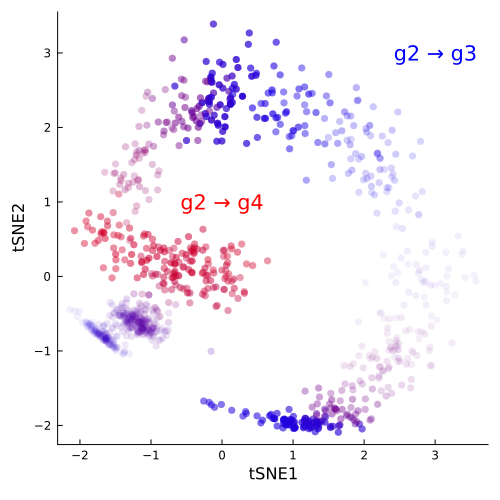

In [79]:
interactions = hcat([reshape(G, :, size(X, 2), size(X, 2))[:, x] for x in [CartesianIndex(2, 3), CartesianIndex(2, 4)]]...)
interactions_norm = interactions ./ sum(interactions; dims = 2)
interactions_norm[isnan.(interactions_norm)] .= 0
plt=scatter(X_umap[:, 1], X_umap[:, 2], markerstrokewidth = 0, c = sum([colorant"blue", colorant"red"]' .* interactions_norm; dims = 2), alpha = normalize(sum(interactions; dims = 2), Inf), legend = nothing,
        size = (PLT_CELL, PLT_CELL), grid = false, xlabel = "tSNE1", ylabel = "tSNE2")
annotate!(3, 3, text("g2 → g3", colorant"blue"))
annotate!(0, 1, text("g2 → g4", colorant"red"))
savefig(string(FIG_DIR, "switch_sim_diff_reg.pdf"))
plt

In [52]:
J_symm = permutedims(cat([locaTE.symm(x) for x in eachslice(abs.(J); dims = 1)]...; dims = 3), [3, 1, 2])
J_static = (mean(abs.(J); dims = 1)[1, :, :] .> 0.1)*1.0
J_static_symm = locaTE.symm(J_static);
J_thresh = 0.5

0.5

In [53]:
# write for TENET
using DataFrames
using CSV
using Glob
DIR_COMPARISON = "/home/stephenz/stephenz/sc-causal-grn/manuscript/data_simulation/comparisons/switcheroo/tenet/"
function process_tenet(path)
    G_tenet = CSV.read(path, DataFrame)
    G_tenet = G_tenet[:, 2:end]
    G_tenet = Array(G_tenet[1:size(X, 2), 1:size(X, 2)])
    # G_tenet = locaTE.CLR(Array(G_tenet))
    # compute AUPR w.r.t ground truth
    p, r = collect(eachcol(prec_rec_rate(J_static, G_tenet, 512)))
    G_tenet, aupr(p, r)
end
tenet_paths = Glob.glob("A_tenet_k*.txt", DIR_COMPARISON)
tenet_results = map(process_tenet, tenet_paths);
G_tenet = first(tenet_results[argmax(map(last, tenet_results))]);

In [54]:
# SCODE
DIR_COMPARISON = "/home/stephenz/stephenz/sc-causal-grn/manuscript/data_simulation/comparisons/switcheroo/scode/"
function process_scode(path)
    G_scode = abs.(Array(CSV.read(string(path, "/A.txt"), DataFrame; header = false)));
    # compute AUPR w.r.t ground truth
    p, r = collect(eachcol(prec_rec_rate(J_static, G_scode, 512)))
    G_scode, aupr(p, r)
end
scode_paths = Glob.glob("SCODE_D_*", DIR_COMPARISON)
scode_results = map(process_scode, scode_paths)
G_scode = first(scode_results[argmax(map(last, scode_results))]);

In [66]:
G_pidc = Array(npzread("G_pidc.npy"));
G_scribe = Array(npzread("scribe/G_scribe.npy"));
G_scribe[diagind(G_scribe)] .= 0;
G_scribe = locaTE.CLR(G_scribe);
G_cespgrn = Array(abs.(preprocess_cespgrn(npzread("cespgrn_output_100_0.25_0.005/G_cespgrn.npy"))));

In [67]:
agg_fun = x -> mean(x; dims = 1)

#38 (generic function with 1 method)

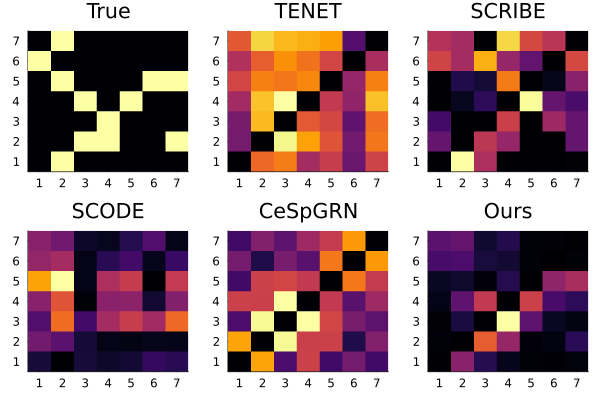

In [68]:
plot(heatmap(J_static, title = "True"), 
    heatmap(G_tenet, title = "TENET"), 
    heatmap(G_scribe, title = "SCRIBE"), 
    heatmap(G_scode, title = "SCODE"), 
    heatmap(reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2)), title = "CeSpGRN"), 
    heatmap(reshape(agg_fun(G), size(X, 2), size(X, 2)), title = "Ours"); 
    colorbar = nothing)

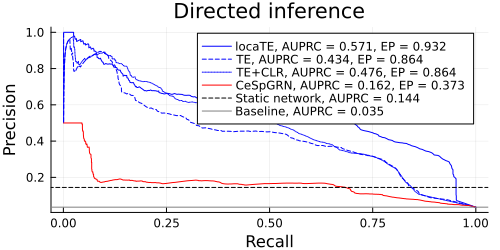

In [76]:
# AUPRC
plt1=plot(; title="Directed inference", size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision")
# locaTE
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G, Nq)))
plot!(r, p; label = @sprintf("locaTE, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
# TE
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), mi_all, Nq)))
plot!(r, p; label = @sprintf("TE, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, linestyle = :dash)
# TE + CLR
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), mi_all_clr, Nq)))
plot!(r, p; label = @sprintf("TE+CLR, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, linestyle = :dot)
# cespgrn (symmetric)
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G_cespgrn, Nq)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
# static baseline
baseline_static = aupr(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), repeat(reshape(J_static, 1, :), size(X, 1)), Nq))...)
hline!([baseline_static, ],
    label = @sprintf("Static network, AUPRC = %0.3f", baseline_static), 
    linestyle = :dash, color = :black)
# baseline 
baseline = mean((R * reshape(abs.(J), :, size(X, 2)^2)) .> 0.5)
hline!([baseline, ]; label = @sprintf("Baseline, AUPRC = %0.3f", baseline), color = :grey)

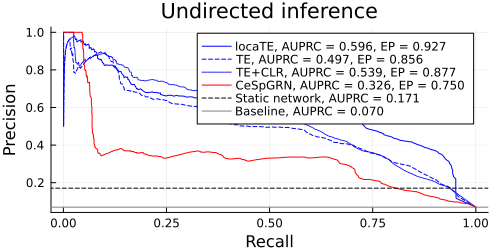

In [77]:
# ours
plt2=plot(; title = "Undirected inference", size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision")
# locaTE
p, r = collect(eachcol(prec_rec_rate(R * reshape(J_symm, :, size(X, 2)*size(X, 2)), G_symm, Nq)))
plot!(r, p; label = @sprintf("locaTE, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
# TE
p, r = collect(eachcol(prec_rec_rate(R * reshape(J_symm, :, size(X, 2)*size(X, 2)), locaTE.symm_row(mi_all, size(X, 2)), Nq)))
plot!(r, p; label = @sprintf("TE, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, linestyle = :dash)
# TE+CLR
p, r = collect(eachcol(prec_rec_rate(R * reshape(J_symm, :, size(X, 2)*size(X, 2)), locaTE.symm_row(mi_all_clr, size(X, 2)), Nq)))
plot!(r, p; label = @sprintf("TE+CLR, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, linestyle = :dot)
# CeSpGRN
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J_symm), :, size(X, 2)*size(X, 2)), G_cespgrn, Nq)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPRC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
# static baseline
baseline_static = aupr(eachcol(prec_rec_rate(R * reshape(abs.(J_symm), :, size(X, 2)*size(X, 2)), repeat(reshape(J_static_symm, 1, :), size(X, 1)), Nq))...)
hline!([baseline_static, ],
    label = @sprintf("Static network, AUPRC = %0.3f", baseline_static),
    linestyle = :dash, color = :black,
    )
# baseline 
baseline = mean((R * reshape(abs.(J_symm), :, size(X, 2)^2)) .> 0.5)
hline!([baseline, ]; label = @sprintf("Baseline, AUPRC = %0.3f", baseline), color = :grey)

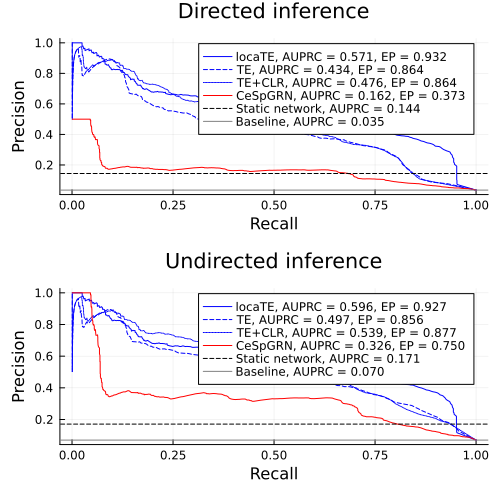

In [78]:
plt=plot(plt1, plt2; layout = (2, 1), size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_sim_pr.pdf"))
plt

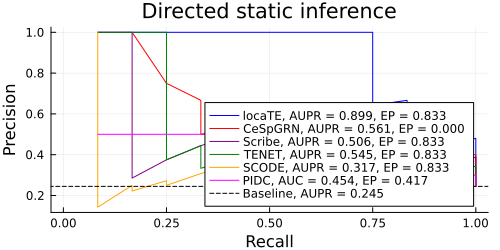

In [72]:
# static, directed
plt1=plot(; title = "Directed static inference", legend = :bottomright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision")
p, r = collect(eachcol(prec_rec_rate(J_static, reshape(agg_fun(G), size(X, 2), size(X, 2)), 512)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_static, reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2)), 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_static, G_scribe, 512)))
plot!(r, p; label = @sprintf("Scribe, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_static, G_tenet, 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_static, G_scode, 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :orange)
p, r = collect(eachcol(prec_rec_rate(J_static, G_pidc, 512)))
plot!(r, p; label = @sprintf("PIDC, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
hline!([mean(J_static), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_static)), color = :black, linestyle = :dash)

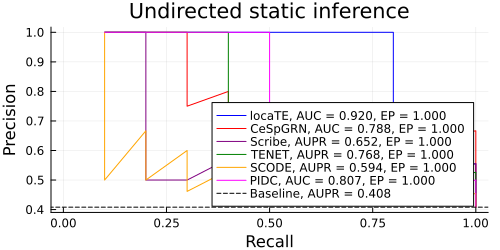

In [74]:
# static, undirected
plt2=plot(; title = "Undirected static inference", legend = :bottomright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision")
p, r = collect(eachcol(prec_rec_rate(J_static_symm, reshape(agg_fun(G_symm), size(X, 2), size(X, 2)), 512)))
plot!(r, p; label = @sprintf("locaTE, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2)), 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, locaTE.symm(G_scribe), 512)))
plot!(r, p; label = @sprintf("Scribe, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, locaTE.symm(G_tenet), 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, locaTE.symm(G_scode), 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :orange)
p, r = collect(eachcol(prec_rec_rate(J_static_symm, G_pidc, 512)))
plot!(r, p; label = @sprintf("PIDC, AUC = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
hline!([mean(J_static_symm), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_static_symm)), color = :black, linestyle = :dash)

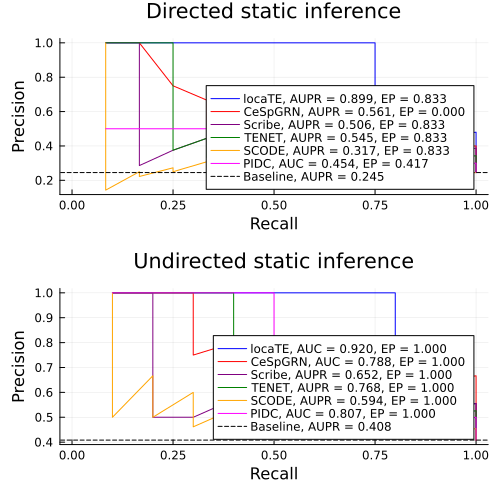

In [75]:
plt=plot(plt1, plt2; layout = (2, 1), size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "switch_sim_pr_static.pdf"))
plt

In [146]:
using Suppressor

In [147]:
# now play with factor analysis
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0

U, V, trace =  fitnmf(relu.(qnorm(mi_all_clr, 0.9)),
                         [I(size(G, 1)), I(size(G, 2))], 1e-3*I + L,
                         repeat(vec(Cg), 1, size(X, 1))',
                         8;
                         α = 25.0,
                         β = 1.0, 
                  λ = [10.0, 10.0],
                  μ = [10.0, 10.0],
                  iter = 2_500, initialize = :nmf, print_iter = 500, dictionary = false, η = 0.5);
G_nmf = U*V';

┌ Info: Initializing NMF decomposition with nmf
└ @ scNetworkInference /home/stephenz/stephenz/scNetworkInference.jl/src/opt.jl:93
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


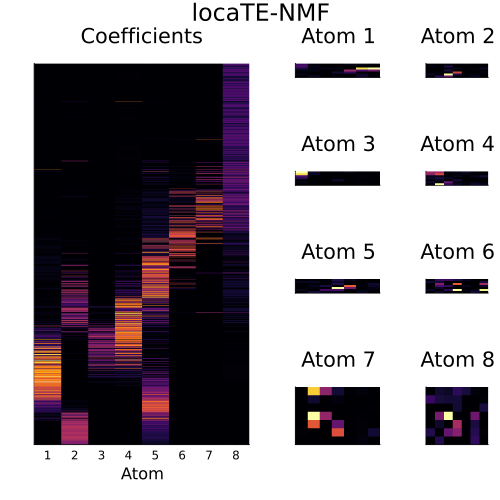

In [148]:
perm = sortperm(vec(sum((U ./ sum(U; dims = 1)) .* dpt; dims = 1)))
# sorted in order of activation
plt2=plot([heatmap(reshape(v, size(X, 2), size(X, 2)); title = "Atom $i", axis = nothing) for (i, v) in enumerate(eachcol(V[:, perm]))]...; colorbar = nothing, layout = (4, 2))
plt1=heatmap(U[sortperm(dpt), perm], colorbar = nothing, size = (PLT_CELL/2, PLT_CELL), yaxis = nothing, title = "Coefficients", xticks = (1:size(U, 2)), xlabel = "Atom")
plt=plot(plt1, plt2; size = (PLT_CELL, PLT_CELL), plot_title = "locaTE-NMF")
savefig(string(FIG_DIR, "switch_sim_nmf_components.pdf"))
plt

In [161]:
# NTF
using TensorToolbox
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
S, A, trace = fitntf(Array(reshape(qnorm(mi_all_clr, 0.9), :, size(X, 2), size(X, 2))),
                     [I(size(X, 1)), I(size(X, 2)), I(size(X, 2))], 1e-3*I + L, repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1)), 
                     [1, 1, 1],
                     [1, 1, 1],
                     25.0,
                     1.0,
                     16; iter = 500, dictionary = false, η = 1);

G_ntf = reshape(ttm(S, A, 1:length(A)), :, size(X, 2)^2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


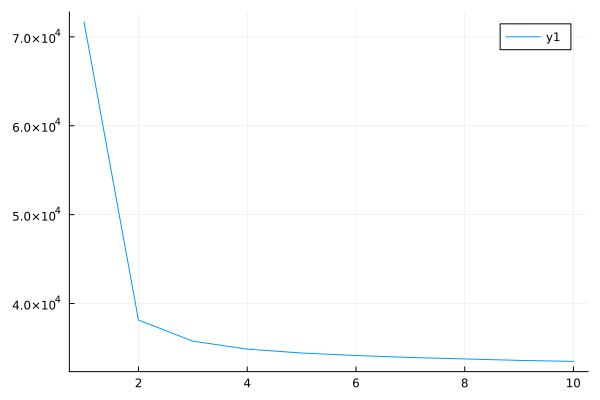

In [162]:
plot(trace)

In [163]:
ntf_atoms = [x*y' for (x, y) in zip(eachcol(A[2]), eachcol(A[3]))];

In [164]:
using Clustering
using StatsPlots
hc = hclust(1 .- cor(A[1]))
clusts = cutree(hc; k = 8)
ntf_atoms_clust_activity = hcat([sum(A[1][:, clusts .== i]; dims = 2) for i = 1:length(unique(clusts))]...)
ntf_atoms_clust = [sum(ntf_atoms[clusts .== i]) for i = 1:length(unique(clusts))];
ntf_atoms_clust_nums = [sum(clusts .== i) for i = 1:length(unique(clusts))];

LoadError: ArgumentError: Distance matrix should be symmetric.

In [165]:
perm_clust = sortperm(vec(sum((ntf_atoms_clust_activity ./ sum(ntf_atoms_clust_activity; dims = 1)) .* dpt; dims = 1)))
perm = sortperm(vec(sum((A[1] ./ sum(A[1]; dims = 1)) .* dpt; dims = 1)))
# sorted in order of activation
plt2=plot([heatmap(x; title = "Cluster $(perm_clust[i]) ($(ntf_atoms_clust_nums[perm_clust[i]]))", axis = nothing, titlefontsize = 12) for (i, x) in enumerate(ntf_atoms_clust[perm_clust])]...; colorbar = nothing, layout = (4, 2))
plt1=heatmap(A[1][sortperm(dpt), perm], colorbar = nothing, size = (PLT_CELL/2, PLT_CELL), yaxis = nothing, title = "Coefficients", xticks = (1:size(A[1], 2), clusts[perm]), xlabel = "Cluster")
plt=plot(plt1, plt2; size = (PLT_CELL, PLT_CELL), plot_title = "locaTE-NTF")
savefig(string(FIG_DIR, "switch_sim_ntf_components.pdf"))
plt

LoadError: UndefVarError: ntf_atoms_clust_activity not defined

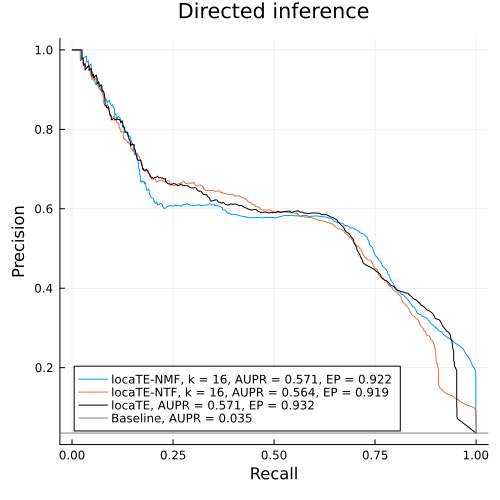

┌ Error: Error watching manifest
│   exception = (Revise.ReviseEvalException("/home/stephenz/.julia/packages/JLLWrappers/QpMQW/src/toplevel_generators.jl:156", MethodError(OpenSSL_jll.var"#make_wrapper_dict#6"{OpenSSL_jll.var"#parse_wrapper_platform#5"}(OpenSSL_jll.var"#parse_wrapper_platform#5"()), ("/home/stephenz/.julia/packages/OpenSSL_jll/FyLfZ/src", ["aarch64-apple-darwin.jl", "aarch64-linux-gnu.jl", "aarch64-linux-musl.jl", "armv6l-linux-gnueabihf.jl", "armv6l-linux-musleabihf.jl", "armv7l-linux-gnueabihf.jl", "armv7l-linux-musleabihf.jl", "i686-linux-gnu.jl", "i686-linux-musl.jl", "i686-w64-mingw32.jl", "powerpc64le-linux-gnu.jl", "x86_64-apple-darwin.jl", "x86_64-linux-gnu.jl", "x86_64-linux-musl.jl", "x86_64-unknown-freebsd.jl", "x86_64-w64-mingw32.jl"]), 0x0000000000007e8b), Any[(top-level scope at toplevel_generators.jl:156, 1)]), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00002b2b6bb3ccea])
└ @ Revise /home/stephenz/.julia/packages/Revise/do2nH/src/pkgs.jl:477

In [166]:
# AUPR
plt=plot(; title="Directed inference", size = (PLT_CELL, PLT_CELL), xlabel = "Recall", ylabel = "Precision", legend = :bottomleft)
# locaTE-NMF
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G_nmf, Nq)))
plot!(r, p; label = @sprintf("locaTE-NMF, k = 16, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)))
# locaTE-NTF
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G_ntf, Nq)))
plot!(r, p; label = @sprintf("locaTE-NTF, k = 16, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)))
# locaTE
p, r = collect(eachcol(prec_rec_rate(R * reshape(abs.(J), :, size(X, 2)*size(X, 2)), G, Nq)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :black)
# baseline 
baseline = mean((R * reshape(abs.(J), :, size(X, 2)^2)) .> 0.5)
hline!([baseline, ]; label = @sprintf("Baseline, AUPR = %0.3f", baseline), color = :grey)
savefig(string(FIG_DIR, "switch_sim_nmf_aupr.pdf"))
plt